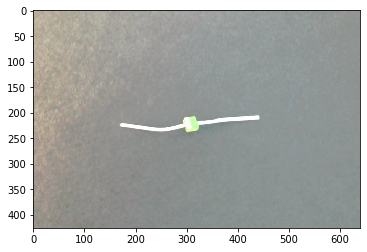

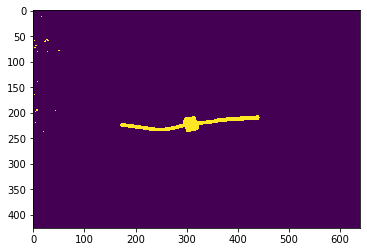

(306, 221)


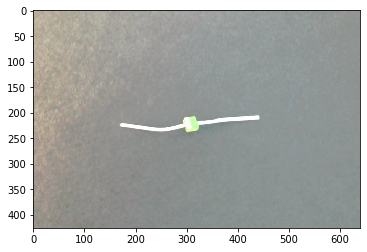

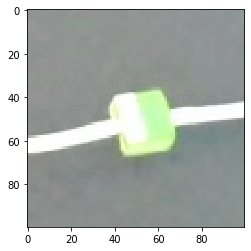

5 99


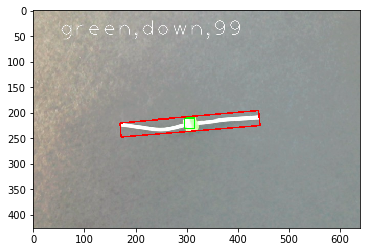

In [51]:
import cv2,glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
from led_camera import ledCamera
import cnn_model

green = np.uint8([[[110,182,0]]])
green_hsv = cv2.cvtColor(green,cv2.COLOR_BGR2HSV)
upper = np.array([green_hsv[0][0][0]+30,green_hsv[0][0][1],green_hsv[0][0][2]])
lower = np.array([upper[0]-40,upper[1]-160,upper[2]-150])

ax = []
ay = []
cut_size_ar = [50,40,30]
pic_size = 50
set_size = 32
thresh = 200
max_pixel = 255
shape = 32
color = 3
in_shape = (shape,shape,color)

#paths = ["./red_ue","./red_yoko","./red_sita","./green_ue","green_yoko","green_sita"]
labels = [0,1,2,3,4,5]
paths = ["./red_ue","./red_yoko","./red_sita","./green_ue","green_yoko","green_sita"]
outfile = "./led.npz"

LABELS = ["red,up","sed,side","red,down","green,up","green,side","green,down"]
model_name = "./phots-model-light.hdf5"

model = cnn_model.get_model(in_shape, len(LABELS))
model.load_weights(model_name)
    
def pic_maxcnt(img):
    new_img = img.copy()
    
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j].argmax() == 1:
                gr = img[i][j][1]
                #print(img[i][j])
                new_img[i][j] = [gr,gr,gr]

    gry_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
    
    #hsv = cv2.cvtColor(new_img, cv2.COLOR_BGR2HSV_FULL)
    #gry_img = hsv[:,:,2]
    ret,new_img = cv2.threshold(gry_img,thresh,max_pixel,cv2.THRESH_BINARY)
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(gry_img)
    plt.subplot(1,3,3)
    plt.imshow(new_img)
    plt.show()

    counturs, hierarchy = cv2.findContours(
                    new_img,
                    cv2.RETR_LIST, 
                    cv2.CHAIN_APPROX_NONE
                    )

    max_cnt = max(counturs, key=lambda x: cv2.contourArea(x))
    return max_cnt

def pic_reshape(path,label):
    # file ロード
    pics = glob.glob(path + "/*.jpg")
    for pic in pics:
        print(pic)
        img = cv2.imread(pic)
        print(img.shape)
        # 最大の輪郭を検出
        max_cnt = pic_maxcnt(img)
        # 形状を検出
        (dx,dy),(MA,ma),angle = cv2.fitEllipse(max_cnt)
        print("(x,y):({0},{1}),(MA,ma):({2},{3}),angle:{4}".format(dx,dy,MA,ma,angle))
        # 角度が水平になるように回転
        center = (int(dx),int(dy))
        angle = angle - 90
        scale = 1.0
        mtx = cv2.getRotationMatrix2D(center, angle, scale)
        img = cv2.warpAffine(img, mtx,(img.shape[1],img.shape[0]))
        # 回転後の最大輪郭
        max_cnt = pic_maxcnt(img)
        # モーメントを計算
        M = cv2.moments(max_cnt)
        # 重心座標を計算
        cent_w = int(M["m10"] / M["m00"])
        cent_h = int(M["m01"] / M["m00"])
        # 切り取りサイズ
        for cut_size in cut_size_ar:
            hs = cent_h - cut_size*2
            he = cent_h + cut_size*2
            ws = cent_w - cut_size*2
            we = cent_w + cut_size*2
            new_img = img[hs:he,ws:we]
            plt.title("new_img hs:{0},he:{1},ws:{2},we:{3}".format(hs,he,ws,we))
            plt.imshow(new_img)
            plt.show()
            # 画像を回転しながら保存
            for i in range(36):
                # 6x6で表示
                plt.subplot(6,6, i+1)
                # 中心座標
                center = (cut_size*2,cut_size*2)
                # 角度
                angle = i * 5
                # 倍率
                scale = 1.0
                # 回転行列
                mtx = cv2.getRotationMatrix2D(center, angle, scale)
                # 回転後の画像サイズ
                cut_shape = (new_img.shape[1],new_img.shape[0])
                # 回転
                img2 = cv2.warpAffine(new_img, mtx, cut_shape)
                # 中心座標
                center = img2.shape[0] / 2
                st = int(center - cut_size)
                ed = int(center + cut_size)
                # 回転した画像を切り取り
                #plt.imshow(img2)
                img2 = img2[st:ed,st:ed]
                #plt.imshow(img2)
                cut_img = cv2.resize(img2,(set_size,set_size))
                plt.imshow(cut_img)
                img_data = cut_img.reshape(-1,)
                ax.append(img_data)
                ay.append(label)
                img3 = cv2.flip(cut_img,1)
                img_data = img3.reshape(-1,)
                ax.append(img_data)
                ay.append(label)
            plt.show()

        
def pic_devide(path):
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()
    width = img.shape[1]
    height = img.shape[0]
    
    y0 = 0
    y1 = y0 + cut_size * 2
    while y1 < height:
        x0 = 0
        x1 = x0 + cut_size * 2
        i = 1
        while x1 < width:
            org_img = img[y0:y1,x0:x1]
            plt.title("org")
            plt.imshow(org_img)
            plt.show()
            '''
            mask,new_img = green_blue(org_img,"white")
            plt.title("white")
            plt.imshow(new_img)
            plt.show()
            gry_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)
            '''
            hsv = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV_FULL)
            gry_img = hsv[:,:,2]
            #gry_img = green_blue(org_img,"green")
            plt.title("gray")
            plt.imshow(gry_img)
            plt.show()
            ret,two_img = cv2.threshold(gry_img, thresh, max_pixel, cv2.THRESH_BINARY)
            plt.title("2tone")
            plt.imshow(two_img)
            plt.show()
            contours, hierarchy = cv2.findContours(
                    two_img,
                    cv2.RETR_TREE, 
                    cv2.CHAIN_APPROX_NONE
                    )
            for i in range(len(contours)):
                con = contours[i]
                hrc = hierarchy[0][i]
                area = cv2.contourArea(con)
                if area < 300:
                    continue
                x,y,w,h = cv2.boundingRect(con)
                #cv2.rectangle(org_img,(x,y),(x+w,y+h),(255,255,255),2)
                plt.title("{0},{1}".format(hrc,area))
                plt.imshow(org_img[y:y+h,x:x+w])
                plt.show()
            plt.title("{0},{1}".format(x1,y1))
            plt.imshow(org_img)
            plt.show()
            x0 = x1
            x1 += cut_size * 2
            i += 1

        y0 = y1
        y1 += cut_size * 2
    return

def green_blue(img,mode):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    mask = np.zeros(h.shape, dtype=np.uint8)
    if mode == "green":
        hsv_min = np.array([30,64,0])
        hsv_max = np.array([130,255,255])
    elif mode == "blue":
        hsv_min = np.array([130,50,0])
        hsv_max = np.array([200,255,255])
    elif mode == "white":
        hsv_min = np.array([0,0,50])
        hsv_max = np.array([50,64,255])
        
    mask = cv2.inRange(hsv,hsv_min,hsv_max)
    masked_img = cv2.bitwise_and(img,img,mask=mask)
    
    return mask,masked_img

def find_led(cp_img):
    image = cp_img
    hsv = cv2.cvtColor(cp_img, cv2.COLOR_BGR2HSV_FULL)
    gry_img = hsv[:,:,2]
    #gry_img = cv2.cvtColor(cp_img,cv2.COLOR_BGR2GRAY)
    ret,new_img = cv2.threshold(gry_img,thresh,max_pixel,cv2.THRESH_BINARY)
    plt.imshow(new_img)
    plt.show()
    contours, hierarchy = cv2.findContours(
                    new_img,
                    cv2.RETR_TREE, 
                    cv2.CHAIN_APPROX_NONE
                    )
    for i in range(len(contours)):
        con = contours[i]
        hrc = hierarchy[0][i]
        mu = cv2.moments(con)
        area = mu["m00"]
        rect = cv2.minAreaRect(con)
        ((x,y),(w,h),r) = rect
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        if w > h:
            length = w
        else:
            length = h

        if 1000 < area and hrc[3] == -1 and 200 < length and length < 500:
            cx,cy = int(mu["m10"]/area),int(mu["m01"]/area)
            idx,per = led_distinction(cp_img,(cx,cy))
            x0 = cx - 10
            x1 = cx + 10
            y0 = cy - 10
            y1 = cy + 10
            cv2.rectangle(cp_img,(x0,y0),(x1,y1),(0,255,0),thickness=2)
            text = "{0},{1}".format(LABELS[idx],per)
            cv2.putText(cp_img,text,(50,50),cv2.FONT_HERSHEY_PLAIN, 3,((255,255,255)),1,cv2.LINE_AA)
            cv2.rectangle(cp_img,(x0,y0),(x1,y1),(0,255,0),thickness=2)
            cv2.drawContours(cp_img,[box],0,(255,0,0),2)

            return (cx,cy),cp_img
    return False,cp_img

def led_distinction(img,center):
    cx,cy = center
    print(center)
    x0 = cx - pic_size
    y0 = cy - pic_size
    x1 = cx + pic_size
    y1 = cy + pic_size
    plt.imshow(img)
    plt.show()
    cut_img = img[y0:y1,x0:x1]
    plt.imshow(cut_img)
    plt.show()
    
    cut_img = cv2.resize(cut_img,(32,32))
    cut_img = cut_img.reshape(-1,32,32,3)
    cut_img = cut_img/255
    pre = model.predict([cut_img])[0]
    idx = pre.argmax()
    per = int(pre[idx] * 100)
    print(idx,per)

    return (idx, per)

def pic_show():
    test_data = np.load('led.npz',allow_pickle=True)
    print(len(test_data))
    x = test_data["x"]
    y = test_data["y"]
    
    #x = x.reshape(-1,32,32,3)
    j = 0
    for i in x:
        print(j,np.shape(i))
        #i = i.reshape(32,32,3)
        '''
        if j%100 == 0:
            plt.imshow(i)
            plt.show()
        '''
        j += 1
        
    
if __name__ == "__main__":
    '''
    for i in range(len(labels)):
        pic_reshape(paths[i],labels[i])
        #print(len(ax))
        #print(ax)
    np.savez(outfile, x=ax, y=ay)
    '''
    #path = "./red_03.jpg"
    #led = find_led(path)
    #plt.imshow(led)
    #pic_devide(path)
    #pic_show()
    #plt.show()
    
    myled = ledCamera()
    img = cv2.imread("./green_sita/2.jpg")
    plt.imshow(img)
    plt.show()
    ret,res_img = find_led(img)
    plt.imshow(res_img)
    plt.show()
    